## Reference

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://pytorch.org/vision/stable/transforms.html

## Libraries

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import classification_report

# Tracking progress
from tqdm import tqdm

# Set Seed
torch.manual_seed(2021)

plt.ion()   # interactive mode

## Load Data

In [2]:
# Just normalization for validation
data_transforms = {
    'mini': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/ubuntu/data/2A_images_reorg'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['mini', 'train', 'val', 'test']}
        
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['mini', 'train', 'val', 'test']}
        
dataset_sizes = {x: len(image_datasets[x]) for x in ['mini', 'train', 'val', 'test']}
class_names = image_datasets['mini'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
print(dataset_sizes)
print(class_names)

{'mini': 10000, 'train': 136445, 'val': 19492, 'test': 19492}
['Covid', 'Normal', 'Pneumonia']


## Sample Image

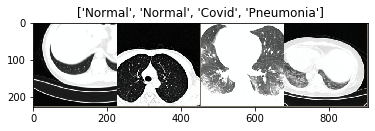

In [4]:
def imshow(inp, title=None):   
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['mini']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Model Function

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, train_='mini'):    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'epoch':[],'train_loss':[],'train_acc':[],"val_loss":[],'val_acc':[]}

    for epoch in tqdm(range(num_epochs), position=0, leave=True):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        history['epoch'].append(epoch)

        # Each epoch has a training and validation phase
        for phase in [train_, 'val']:
            if phase == train_:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == train_:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == train_:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # store statistics
            if phase == train_:
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

Visual Model Predictions

In [58]:
def visualize_model(model, num_images=6, pred_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    eval_history = {'predict':[], 'actual':[]}

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            prob = nn.functional.softmax(outputs, dim=1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if images_so_far <= num_images:
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('(pred,actual): ({0},{1},{2})'.\
                                 format(class_names[preds[j]], 
                                        class_names[labels[j]],
                                        round(prob[j][preds[j]].item(),3)))
                    imshow(inputs.cpu().data[j])

                    eval_history['predict'].append(class_names[preds[j]])
                    eval_history['actual'].append(class_names[labels[j]])
                
                elif images_so_far < pred_images:
                    eval_history['predict'].append(class_names[preds[j]])
                    eval_history['actual'].append(class_names[labels[j]])
                    
                elif images_so_far == pred_images:
                    model.train(mode=was_training)
                    return eval_history
        model.train(mode=was_training)

## Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [63]:
# Load pretratined model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Reset final fully connected layer
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Model to GPU
model_ft = model_ft.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
#models.resnet18(pretrained=True)

## Train and evaluate - on mini dataset
Takes about 15 minutes for 10 epochs

In [64]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15, train_='mini')

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/14
----------
mini Loss: 0.6414 Acc: 0.7679


  7%|▋         | 1/15 [01:27<20:22, 87.35s/it]

val Loss: 0.3111 Acc: 0.8916

Epoch 1/14
----------
mini Loss: 0.4392 Acc: 0.8502


 13%|█▎        | 2/15 [02:55<18:59, 87.67s/it]

val Loss: 0.1142 Acc: 0.9646

Epoch 2/14
----------
mini Loss: 0.3561 Acc: 0.8785


 20%|██        | 3/15 [04:23<17:32, 87.69s/it]

val Loss: 0.1242 Acc: 0.9605

Epoch 3/14
----------
mini Loss: 0.3071 Acc: 0.9007


 27%|██▋       | 4/15 [05:51<16:04, 87.68s/it]

val Loss: 0.3281 Acc: 0.8776

Epoch 4/14
----------
mini Loss: 0.2695 Acc: 0.9122


 33%|███▎      | 5/15 [07:18<14:37, 87.70s/it]

val Loss: 0.2270 Acc: 0.9201

Epoch 5/14
----------
mini Loss: 0.2408 Acc: 0.9226


 40%|████      | 6/15 [08:48<13:14, 88.25s/it]

val Loss: 0.0956 Acc: 0.9701

Epoch 6/14
----------
mini Loss: 0.2132 Acc: 0.9304


 47%|████▋     | 7/15 [10:15<11:42, 87.79s/it]

val Loss: 0.0659 Acc: 0.9778

Epoch 7/14
----------
mini Loss: 0.1507 Acc: 0.9511


 53%|█████▎    | 8/15 [11:42<10:13, 87.62s/it]

val Loss: 0.2649 Acc: 0.9073

Epoch 8/14
----------
mini Loss: 0.1331 Acc: 0.9570


 60%|██████    | 9/15 [13:10<08:45, 87.65s/it]

val Loss: 0.0694 Acc: 0.9772

Epoch 9/14
----------
mini Loss: 0.1207 Acc: 0.9588


 67%|██████▋   | 10/15 [14:39<07:20, 88.03s/it]

val Loss: 0.0603 Acc: 0.9827

Epoch 10/14
----------
mini Loss: 0.1144 Acc: 0.9624


 73%|███████▎  | 11/15 [16:07<05:52, 88.13s/it]

val Loss: 0.0514 Acc: 0.9848

Epoch 11/14
----------
mini Loss: 0.1256 Acc: 0.9584


 80%|████████  | 12/15 [17:34<04:23, 87.88s/it]

val Loss: 0.0499 Acc: 0.9846

Epoch 12/14
----------
mini Loss: 0.1173 Acc: 0.9582


 87%|████████▋ | 13/15 [19:02<02:55, 87.87s/it]

val Loss: 0.0519 Acc: 0.9854

Epoch 13/14
----------
mini Loss: 0.1109 Acc: 0.9617


 93%|█████████▎| 14/15 [20:30<01:27, 87.91s/it]

val Loss: 0.0586 Acc: 0.9819

Epoch 14/14
----------
mini Loss: 0.1028 Acc: 0.9659


100%|██████████| 15/15 [21:59<00:00, 87.94s/it]

val Loss: 0.0492 Acc: 0.9853

Training complete in 21m 59s
Best val Acc: 0.985379


## Model Performance

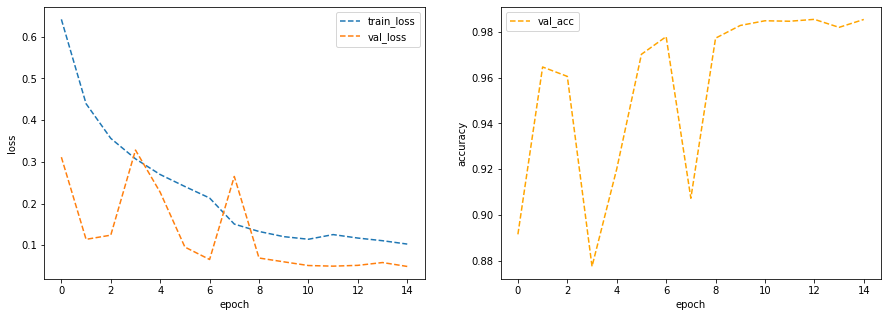

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax[0].plot(history['epoch'], history['train_loss'], label='train_loss', linestyle='--')
ax[0].plot(history['epoch'], history['val_loss'], label='val_loss', linestyle='--')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

# Accuracy
ax[1].plot(history['epoch'], history['val_acc'], label='val_acc', linestyle='--', color='orange')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

## Visualize Model Output

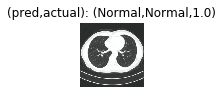

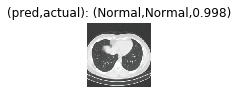

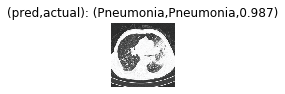

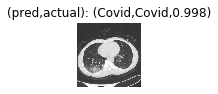

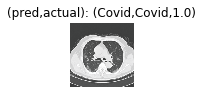

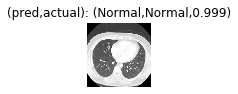

In [66]:
eval_history = visualize_model(model_ft, num_images=6, pred_images=dataset_sizes['test'])

## Evaluation

In [67]:
print(classification_report(eval_history['actual'], eval_history['predict'], digits=3))

              precision    recall  f1-score   support

       Covid      0.988     0.982     0.985      9335
      Normal      0.985     0.989     0.987      6058
   Pneumonia      0.971     0.977     0.974      4098

    accuracy                          0.983     19491
   macro avg      0.981     0.983     0.982     19491
weighted avg      0.983     0.983     0.983     19491



## Export Weights

In [68]:
torch.save(model_ft.state_dict(), '/home/ubuntu/w251_transfer_learning_weights')

## Train and Evaluate - on Full Train Set

The full trainset is used below.

Reload model

In [69]:
# lLad pretratined model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Reset final fully connected layer
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Model to GPU
model_ft = model_ft.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train model

In [70]:
model_ft_full, history_full = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15, train_='train')

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0/14
----------
train Loss: 0.2647 Acc: 0.9089


  7%|▋         | 1/15 [10:31<2:27:18, 631.33s/it]

val Loss: 0.0516 Acc: 0.9838

Epoch 1/14
----------
train Loss: 0.1181 Acc: 0.9587


 13%|█▎        | 2/15 [20:49<2:15:56, 627.40s/it]

val Loss: 0.0342 Acc: 0.9892

Epoch 2/14
----------
train Loss: 0.0935 Acc: 0.9669


 20%|██        | 3/15 [31:03<2:04:40, 623.39s/it]

val Loss: 0.0435 Acc: 0.9850

Epoch 3/14
----------
train Loss: 0.0805 Acc: 0.9712


 27%|██▋       | 4/15 [41:17<1:53:45, 620.52s/it]

val Loss: 0.0268 Acc: 0.9915

Epoch 4/14
----------
train Loss: 0.0710 Acc: 0.9745


 33%|███▎      | 5/15 [51:34<1:43:16, 619.63s/it]

val Loss: 0.0252 Acc: 0.9918

Epoch 5/14
----------
train Loss: 0.0645 Acc: 0.9775


 40%|████      | 6/15 [1:01:49<1:32:41, 617.99s/it]

val Loss: 0.0186 Acc: 0.9946

Epoch 6/14
----------
train Loss: 0.0607 Acc: 0.9785


 47%|████▋     | 7/15 [1:12:03<1:22:14, 616.85s/it]

val Loss: 0.0170 Acc: 0.9946

Epoch 7/14
----------
train Loss: 0.0418 Acc: 0.9855


 53%|█████▎    | 8/15 [1:22:22<1:12:02, 617.55s/it]

val Loss: 0.0133 Acc: 0.9957

Epoch 8/14
----------
train Loss: 0.0371 Acc: 0.9872


 60%|██████    | 9/15 [1:32:41<1:01:47, 617.95s/it]

val Loss: 0.0102 Acc: 0.9972

Epoch 9/14
----------
train Loss: 0.0351 Acc: 0.9881


 67%|██████▋   | 10/15 [1:42:59<51:30, 618.09s/it] 

val Loss: 0.0109 Acc: 0.9971

Epoch 10/14
----------
train Loss: 0.0345 Acc: 0.9879


 73%|███████▎  | 11/15 [1:53:15<41:09, 617.34s/it]

val Loss: 0.0096 Acc: 0.9972

Epoch 11/14
----------
train Loss: 0.0329 Acc: 0.9883


 80%|████████  | 12/15 [2:03:34<30:53, 617.72s/it]

val Loss: 0.0093 Acc: 0.9976

Epoch 12/14
----------
train Loss: 0.0330 Acc: 0.9888


 87%|████████▋ | 13/15 [2:13:49<20:34, 617.14s/it]

val Loss: 0.0092 Acc: 0.9978

Epoch 13/14
----------
train Loss: 0.0317 Acc: 0.9890


 93%|█████████▎| 14/15 [2:24:01<10:15, 615.48s/it]

val Loss: 0.0092 Acc: 0.9973

Epoch 14/14
----------
train Loss: 0.0302 Acc: 0.9894


100%|██████████| 15/15 [2:34:18<00:00, 617.27s/it]

val Loss: 0.0096 Acc: 0.9975

Training complete in 154m 19s
Best val Acc: 0.997794


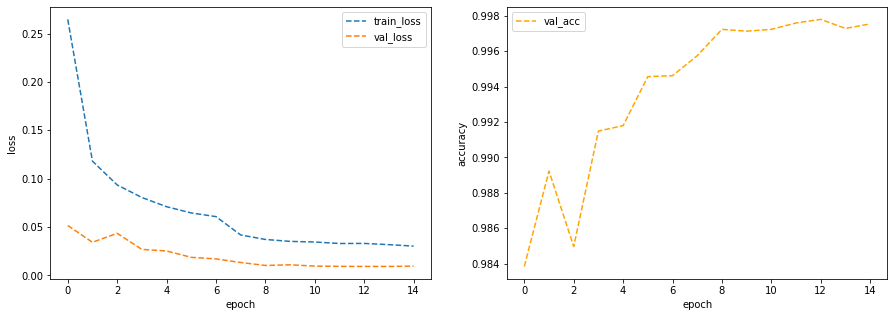

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

#  Loss
ax[0].plot(history_full['epoch'], history_full['train_loss'], 
           label='train_loss', linestyle='--')
ax[0].plot(history_full['epoch'], history_full['val_loss'], 
           label='val_loss', linestyle='--')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

# Accuracy
ax[1].plot(history_full['epoch'], history_full['val_acc'], 
           label='val_acc', linestyle='--', color='orange')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

Evaluate model

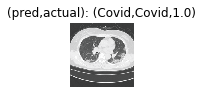

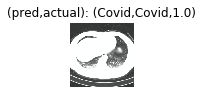

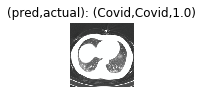

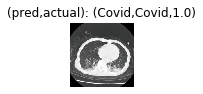

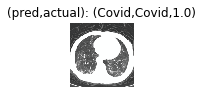

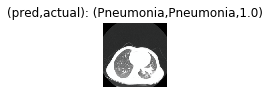

In [72]:
eval_history_full = visualize_model(model_ft_full, num_images=6, pred_images=dataset_sizes['test'])

In [73]:
print(classification_report(eval_history_full['actual'], eval_history_full['predict'], digits=3))

              precision    recall  f1-score   support

       Covid      0.997     0.998     0.997      9336
      Normal      0.998     0.998     0.998      6057
   Pneumonia      0.997     0.995     0.996      4098

    accuracy                          0.997     19491
   macro avg      0.997     0.997     0.997     19491
weighted avg      0.997     0.997     0.997     19491



Export Model

In [76]:
torch.save(model_ft_full.state_dict(), '/home/ubuntu/w251_transfer_learning_weights_full')

## Test for NX

In [24]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import PIL
import time

In [2]:
# Path of pre-trained model
PATH = '/home/ubuntu/w251_transfer_learning_weights'

In [116]:
# to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pretratined model into resnet18
model_tl = models.resnet18(pretrained=True)
num_ftrs = model_tl.fc.in_features

# Load pretrained weights into FC layer
model_tl.fc = nn.Linear(num_ftrs, 3)
model_tl.load_state_dict(torch.load(PATH))

# Push model to GPU
model_tl = model_tl.to(device)

In [121]:
def prediction(model, image):
    
    # Index for classes
    class_names = ['Covid', 'Normal', 'Pneumonia']
    
    # Put model to evaluation mode
    model.eval()  

    # Transform image for the model
    data_transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    inputs = data_transform(image) 
    
    # Make 4D for Resnet: (batch, channel, width, height)
    inputs = inputs.cuda().float().unsqueeze(0)   
    
    # Prediction with model - outputs class and probability
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        prob = nn.functional.softmax(outputs, dim=1)
        
        print(class_names[preds[0]], ': %0.3f' %prob[0][preds[0]].item())

In [125]:
image = os.listdir('/home/ubuntu/data/2A_images_reorg/test/Pneumonia')[300]
image_path = '/home/ubuntu/data/2A_images_reorg/test/Pneumonia/' + image

# Read in image using CV2 and convert to PIL for transformations
img = cv2.imread(image_path)
img = PIL.Image.fromarray(img).convert('RGB')

In [126]:
prediction(model_tl, img)

Pneumonia : 1.000
